In [1]:
import os
import pandas as pd
import numpy as np
import warnings
import random
warnings.filterwarnings('ignore')

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor, AdaBoostRegressor, RandomForestRegressor
from sklearn.ensemble import BaggingRegressor, GradientBoostingRegressor
from sklearn.model_selection import KFold, GroupKFold, LeavePGroupsOut
from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict
from sklearn.metrics import r2_score, make_scorer, roc_auc_score, precision_recall_curve, auc, mean_absolute_error
from sklearn.neural_network import MLPRegressor
from sklearn import svm
from sklearn import linear_model

from mlxtend.feature_selection import SequentialFeatureSelector
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

from scipy.stats import pearsonr, sem

import matplotlib as mpl
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

import pickle
import json

In [2]:
# ======================================
# Function we will use for scatter plots
# ======================================
def plot_corr(ax, x, y, xerr=None, yerr=None, xlim=[-5,+5], ylim=[-5,+5], title='', legendloc=None,
              fit=True, diagonal=True, labelsize=16, msize=90, yax=1.36, xax=1.36,
              colorbar=False, vmin=0.0, vmax=2.8, cbarlabel='cbar', cbar_shrink=1.0, cbar_pad=0.15):
  
    # the absolute error for each data point
    diff = np.abs(x-y)
    cmap = plt.cm.coolwarm
    
    SC = ax.scatter(x=x, y=y, c=diff, cmap=cmap, s=msize, edgecolors='k', linewidths=1.2, zorder=10, 
                vmin=0.0, vmax=2.8, label='_nolegend_')
    
    if yerr is None and xerr is not None:
        ax.errorbar(x=x, y=y, xerr=xerr, fmt=None, marker=None, 
                color='k', linewidth=1.2, zorder=0, label='_nolegend_')
    elif yerr is not None and xerr is not None:
        ax.errorbar(x=x, y=y, xerr=xerr, yerr=yerr, fmt='none', marker=None, 
                color='k', linewidth=1.2, zorder=0, label='_nolegend_')
    
    # Make ColorBar
    if colorbar is True:
        cbarticks = [0.0, 0.7, 1.4, 2.1, 2.8]
        cbar = fig.colorbar(SC, ax=ax, shrink=cbar_shrink, pad=cbar_pad, ticks=cbarticks)
        cbar.set_label(cbarlabel, fontsize=labelsize)
        cax = plt.gcf().axes[-1]
        cax.tick_params(labelsize=labelsize)
    
    # Ticks and labels
    ax.set_xlabel(r'Experimental $\Delta\Delta G$, kcal/mol', fontsize=labelsize)
    ax.set_ylabel(r'Calculated $\Delta\Delta G$, kcal/mol', fontsize=labelsize)
  
    ax.tick_params(axis='x', labelsize=labelsize)
    ax.tick_params(axis='y', labelsize=labelsize)
    
    xmin = min(xlim)
    xmax = max(xlim)
    ymin = min(ylim)
    ymax = max(ylim)
    
    if title != '':
        ax.set_title(title, fontsize=labelsize*1.2)
    
    # add diagonal
    if diagonal is True:
        ax.plot([xmin,xmax], [xmin,xmax], '--', color='gray')

    # add zero axes
    ax.axvline(x=xax, color='k', linestyle='-', linewidth=1.2)
    ax.axhline(y=yax, color='k', linestyle='-', linewidth=1.2)
    
    # shaded area indicating 1,2 kcal/mol errors
    a = [xmin,xmax]
    b = [j+1.4 for j in a]
    c = [j-1.4 for j in a]
    ax.fill_between(a, b, c, alpha=0.1, interpolate=True, color='k')
    
    # Linear fit
    if fit is True:
        fit = np.polyfit(x, y, 1)
        fit_fn = np.poly1d(fit)
        x_fit = np.linspace(xmin, xmax, len(x)) 
        y_fit = fit_fn(x_fit)
        ax.plot(x_fit, y_fit, '-', color='k', zorder=1, 
                label='$\Delta\Delta G_{calc} = %.2f \cdot \Delta\Delta G_{exp} %+.2f$' %(fit[0],fit[1]))

    # grid
    ax.grid(b=True, which='major', color='0.5',linestyle=':')

    ax.set_xlim([xmax,xmin])
    ax.set_ylim([ymax,ymin])
    
    # Make box square
    x0,x1 = ax.get_xlim()
    y0,y1 = ax.get_ylim()
    ax.set_aspect(aspect=(x1-x0)/(y1-y0))
    
    # make legend
    if legendloc is not None:
        legend = ax.legend(loc=legendloc, prop={'size':labelsize*0.8})

# ====================
# Performance measures
# ====================
def get_rmse(x,y):
    return np.sqrt((np.mean((x-y)**2)))


def get_pearson(x,y):
    return pearsonr(x,y)[0]


def get_auc_roc(y,y_pred):
    true_bool = np.array([i > 0.0 for i in y])
    scores = np.array(y_pred)
    auc = roc_auc_score(true_bool, scores)
    return auc

def get_R2(x, y):
    return r2_score(x, y)

def get_mae(x, y):
    return mean_absolute_error(x, y)


def get_auc_prc(exp, calc):
    true_bool = np.array([x > 1.36 for x in exp]) # identify resistant mutations (ddG > 1.36 kcal/mol)
    scores = np.array(calc) # the scores are the calc ddg (higher ddg = higher probability of resistance)
    precision, recall, thresholds = precision_recall_curve(true_bool, scores)
    auc_score = auc(recall, precision)
    return auc_score
    
    
# define additional sklearn scores
my_pearson = make_scorer(get_pearson, greater_is_better=True)
my_rmse = make_scorer(get_rmse, greater_is_better=False)
my_roc = make_scorer(get_auc_roc, greater_is_better=True)
my_prc = make_scorer(get_auc_prc, greater_is_better=True)

In [3]:
def SplitbyGroup(x, y, group, split_ratio=0.8, seed=10, flag=False):
    
    random.seed(seed)
    group_uniq = list(group.unique())
    group_num = len(group_uniq)
    group_num_train = int(group_num * split_ratio)
    group_num_test = group_num - group_num_train
    
    print(f"The group of training: {group_num_train}; The group of test: {group_num_test}")
        
    select_train_idx = random.sample(list(range(0, group_num)), group_num_train)
    select_test_idx = list(set(list(range(0, group_num))) - set(select_train_idx))
    
    select_train_info = [group_uniq[i] for i in select_train_idx]
    select_test_info = [group_uniq[i] for i in select_test_idx]
    
    sample_test_idx = []
    sample_train_idx = []
    for i in group.index:
        if group[i] in select_test_info:
            sample_test_idx.append(i)
        elif group[i] in select_train_info:
            sample_train_idx.append(i)
    
    X_train = X.iloc[sample_train_idx].reset_index(drop=True)
    X_test = X.iloc[sample_test_idx].reset_index(drop=True)
    
    Y_train = Y[sample_train_idx].reset_index(drop=True)
    Y_test = Y[sample_test_idx].reset_index(drop=True)
    
    print(f"Number of training samples: {len(sample_train_idx)}; Number of test samples: {len(sample_test_idx)}")
    
    if flag == True:
        return X_train, Y_train, X_test, Y_test, select_train_info, select_test_info
    else:
        return X_train, Y_train, X_test, Y_test
    
def InstantiationModel(model_name):
    
    if model_name == 'ElasticNet':
        model = linear_model.ElasticNet(alpha=0.1,l1_ratio=0.5)
    elif model_name == 'Lasso':
        model = linear_model.Lasso(alpha=0.1)
    elif model_name == 'DecisionTree':
        model = DecisionTreeRegressor()
    elif model_name == 'RandomForest':
        model = RandomForestRegressor(n_estimators=500, n_jobs= -1)
    elif model_name == 'ExtraTrees':
        model = ExtraTreesRegressor(n_estimators=500, n_jobs= -1)
    elif model_name == 'Bagging':
        model = BaggingRegressor(n_estimators=500, n_jobs= -1)
    elif model_name == 'AdaBoost':
        model = AdaBoostRegressor(n_estimators=500)
    elif model_name == 'GradientBoost':
        model = GradientBoostingRegressor(n_estimators=500)
    elif model_name == 'SVR':
        model = svm.SVR()
    elif model_name == 'MLP':
        model = MLPRegressor(hidden_layer_sizes=(64, 128, 64, ), activation='relu', solver='adam', alpha=0.0001, batch_size='auto', learning_rate='constant', learning_rate_init=0.001)
    
    return model

def save_obj(data, save_filename, save_path):
    tf = open(f"{save_path}/{save_filename}.pkl", "wb")
    pickle.dump(data, tf)
    tf.close()
    
def load_obj(save_filename, save_path):
    tf = open(f"{save_path}/{save_filename}.pkl", "rb")
    data = pickle.load(tf)
    tf.close()
    return data

### Scenario 2. Platinum _ KTI
____
Training on the Platinum dataset, then test the machine learning methods on the TKI dataset.

In [4]:
import os
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

import random

import pickle

In [5]:
mdrdb = pd.read_csv("../data/MdrDB_CoreSet_release_v1.0.2022.tsv", sep = '\t')
mdrdb = mdrdb[mdrdb["TYPE"] == "Single Substitution"].reset_index(drop=True)

Y = mdrdb[['SAMPLE_ID', 'DATASET', 'DDG.EXP']]
todrop = ['VERSION', 'TYPE', 'UNIPROT_ID', 'SAMPLE_PDB_ID', 'MUTATION', 'DRUG', 'SMILES', 'PROTEIN_NAME', 
          'PROTEIN_FAMILY', 'PROTEIN_SUPERFAMILY', 'PROTEIN_DOMAIN', 'CID', 'FDA_MECHANISM', 'MESH', 'DRUG_CLASSES', 'DDG.EXP', 
          'SAMPLE_SOURCE', 'MUTATION_SOURCE', 'DRUG_POSE_SOURCE',]
mdrdb = mdrdb.drop(todrop, axis=1)

In [6]:
print(f"The number of sampels in mdrdb: {len(mdrdb)}")
mdrdb.head()

The number of sampels in mdrdb: 3697


,SAMPLE_ID,DATASET,LIG.MolLogP,LIG.MolWt,LIG.LabuteASA,LIG.TPSA,LIG.NumAromaticRings,LIG.NumRotatableBonds,LIG.FractionCSP3,LIG.NumHDonors,...,P2dp.P,P2dp.N,P2dp.DA,P2dp.D,P2dp.A,P2dp.AR,P2dp.H,P2dp.PL,P2dp.HA,P2dp.SA
0,MdrDBcore00052,AIMMS,1.526,251.721,104.784,80.00,1.0,1.0,0.273,2.0,...,0.0,0.0,0.0,0.0,6.76,-1.76,-11.03,-2.37,0.0,-8.40
1,MdrDBcore00053,AIMMS,2.524,248.717,104.641,77.82,2.0,2.0,0.167,2.0,...,0.0,0.0,0.0,0.0,7.93,-1.65,-8.81,-2.38,0.0,-4.90
2,MdrDBcore00054,AIMMS,1.526,251.721,104.784,80.00,1.0,1.0,0.273,2.0,...,0.0,0.0,0.0,0.0,0.67,1.54,-6.07,4.33,0.0,0.47
3,MdrDBcore00055,AIMMS,2.524,248.717,104.641,77.82,2.0,2.0,0.167,2.0,...,0.0,0.0,0.0,0.0,0.40,1.14,-4.57,3.41,0.0,0.38
4,MdrDBcore00056,AIMMS,1.526,251.721,104.784,80.00,1.0,1.0,0.273,2.0,...,0.0,0.0,0.0,0.0,7.85,-1.45,-8.63,-1.14,0.0,-3.36


In [7]:
X_train = mdrdb[mdrdb["DATASET"] == 'Platinum'].reset_index(drop=True).drop(["SAMPLE_ID", "DATASET"], axis=1)
Y_train = Y[Y["DATASET"] == 'Platinum'].reset_index(drop=True).drop(["SAMPLE_ID", "DATASET"], axis=1)
X_train = X_train.astype(float)
Y_train = Y_train["DDG.EXP"]
print(f"Number of training samples (Plaitnum): {len(X_train)}")

Number of training samples (Plaitnum): 649


In [8]:
X_test = mdrdb[mdrdb["DATASET"] == "TKI"].reset_index(drop=True).drop(["SAMPLE_ID", "DATASET"], axis=1)
Y_test =Y[Y["DATASET"] == 'TKI'].reset_index(drop=True).drop(["SAMPLE_ID", "DATASET"], axis=1)
X_test = X_test.astype(float)
Y_test = Y_test["DDG.EXP"]
print(f"Number of test samples (TKI): {len(X_test)}")

Number of test samples (TKI): 144


In [9]:
models_list = ['DecisionTree', 'RandomForest', 'ExtraTrees', 'Bagging', 'AdaBoost', 'GradientBoost', 'SVR', 'ElasticNet', 'Lasso', 'MLP']
print(f"Number of models: {len(models_list)}")

Number of models: 10


In [10]:
models_list_test = ['ElasticNet']
iteration = 5

# 初始化
results = pd.DataFrame()      # 数据框类型，记录预测 y 值
rmse_dict = {}                # 字典类型， 记录模型预测性能
mae_dict = {}
r2_dict = {}
pears_dict = {}
prc_dict = {}

result_dict = {}
result_dict[f"label_true"] = Y_test

# 运行多次实验，获取实验结果
for i in range(iteration):
    seed = random.randint(0,100)
    print(f"Seed: {seed}")
    
    for m in models_list:
        model = InstantiationModel(m)
        
        model.fit(X_train, Y_train)
        y_pred = model.predict(X_test)
        col_name = f'{m}_iter_{i}'
        result_dict[col_name] = y_pred
        
        # performance
        RMSE = get_rmse(Y_test, y_pred)
        MAE = get_mae(Y_test, y_pred)
        R2 = get_R2(Y_test, y_pred)
        Pears = get_pearson(Y_test, y_pred)
        PRC = get_auc_prc(Y_test, y_pred)
        
        if m in rmse_dict.keys():
            rmse_dict[m].append(RMSE)
            mae_dict[m].append(MAE)
            r2_dict[m].append(R2)
            pears_dict[m].append(Pears)
            prc_dict[m].append(PRC)
        else:
            rmse_dict[m] = [RMSE]
            mae_dict[m] = [MAE]
            r2_dict[m] = [R2]
            pears_dict[m] = [Pears]
            prc_dict[m] = [PRC]
            
    print(f"Finish the {i}-th iteration.")

Seed: 75
Finish the 0-th iteration.
Seed: 61
Finish the 1-th iteration.
Seed: 82
Finish the 2-th iteration.
Seed: 97
Finish the 3-th iteration.
Seed: 81
Finish the 4-th iteration.


In [11]:
# 统计结果
results = pd.DataFrame(columns=['Methods', 'RMSE_avg', 'RMSE_std', 'MAE_avg', 'MAE_std', 'R2_avg', 'R2_std', 'Pearson_avg', 'Pearson_std', 'PR_AUC_avg', 'PR_AUC_std'])

row_idx = 0
for i in rmse_dict.keys():
    results.loc[row_idx] = [i, np.mean(rmse_dict[i]), np.var(rmse_dict[i]), np.mean(mae_dict[i]), np.var(mae_dict[i]), np.mean(r2_dict[i]), np.var(r2_dict[i]), np.mean(pears_dict[i]), np.var(pears_dict[i]), np.mean(prc_dict[i]), np.var(prc_dict[i])]
    row_idx += 1
results = results.round(3)

# 保存 performance
save_file = True
if save_file == True:
    results.to_csv("../results/2-Scenario2_all_features_performance.tsv", sep='\t')
else:
    pass

# 保存预测值
if save_file == True:
    save_obj(data=result_dict, save_filename="2-Scenario2_all_features_results", save_path="../results")
else:
    pass

results

,Methods,RMSE_avg,RMSE_std,MAE_avg,MAE_std,R2_avg,R2_std,Pearson_avg,Pearson_std,PR_AUC_avg,PR_AUC_std
0,DecisionTree,1.231,0.001,0.851,0.000,-1.249,0.007,0.204,0.001,0.296,0.000
1,RandomForest,0.847,0.000,0.538,0.000,-0.064,0.000,0.204,0.000,0.247,0.000
2,ExtraTrees,0.907,0.000,0.597,0.000,-0.221,0.000,0.094,0.000,0.243,0.000
3,Bagging,0.842,0.000,0.537,0.000,-0.052,0.001,0.207,0.001,0.263,0.000
4,AdaBoost,0.865,0.000,0.589,0.000,-0.110,0.001,0.155,0.001,0.277,0.000
5,GradientBoost,0.985,0.000,0.689,0.000,-0.439,0.000,0.193,0.000,0.292,0.000
6,SVR,0.786,0.000,0.573,0.000,0.084,0.000,0.335,0.000,0.376,0.000
7,ElasticNet,0.909,0.000,0.640,0.000,-0.225,0.000,0.219,0.000,0.208,0.000
8,Lasso,0.921,0.000,0.701,0.000,-0.258,0.000,0.236,0.000,0.235,0.000
9,MLP,1.397,0.009,0.955,0.006,-1.908,0.153,0.115,0.004,0.218,0.002


In [12]:
data = load_obj(save_filename='2-Scenario2_all_features_results', save_path="../results")
data_onetime = {}
for i in data.keys():
    if "1" in i or "label_true" in i:
        data_onetime[i] = data[i]
data_onetime = pd.DataFrame(data_onetime)
data_onetime.head()

,label_true,DecisionTree_iter_1,RandomForest_iter_1,ExtraTrees_iter_1,Bagging_iter_1,AdaBoost_iter_1,GradientBoost_iter_1,SVR_iter_1,ElasticNet_iter_1,Lasso_iter_1,MLP_iter_1
0,0.179,0.696,0.488630,0.687972,0.592244,0.971462,0.253956,0.353988,-0.057318,0.216617,-0.886377
1,0.894,-0.255,0.274974,0.172296,0.256362,0.476390,0.602796,0.572031,0.749644,0.702733,1.024795
2,0.258,0.696,0.590346,0.802584,0.634574,0.943203,1.050125,0.478499,0.183642,0.437302,-0.690105
3,0.557,-0.255,0.496988,0.339542,0.500516,1.094407,0.860108,0.656637,0.727759,0.774245,0.096033
4,1.014,-0.255,0.157390,0.123330,0.241994,-0.130558,0.643978,0.567264,0.704246,0.716936,0.405985


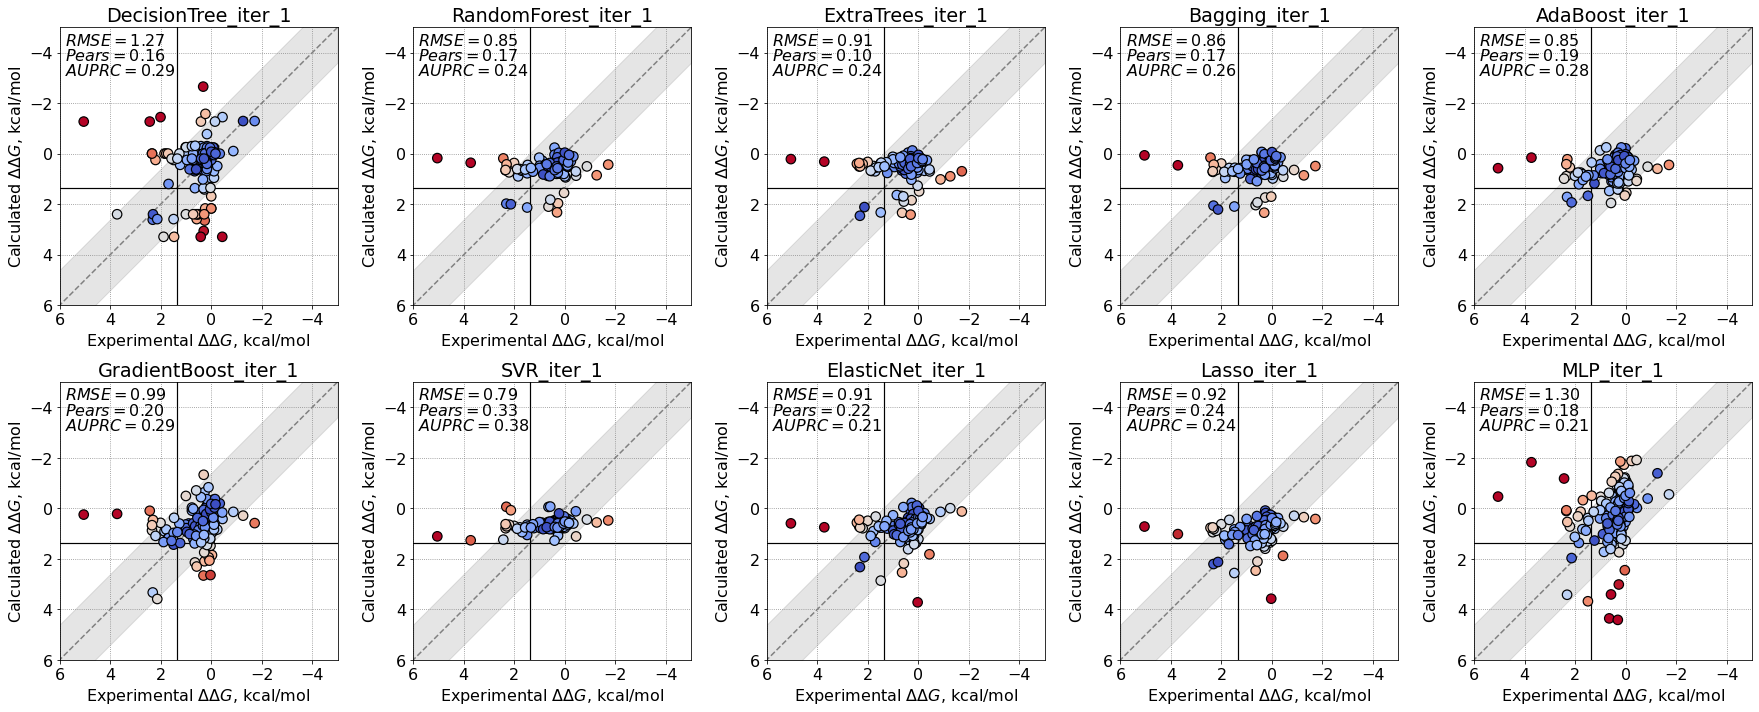

In [13]:
ncols = 5
nrows=int((data_onetime.shape[1]-1)/ncols)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols, 5*nrows))

x_axis = 0
y_axis = 0
for i in range(1, data_onetime.shape[1]):
    ddg_exp = data_onetime.iloc[:, 0]
    ddg_calc = data_onetime.iloc[:, i]
    
    if nrows == 1:
        ax = axes[x_axis]
    else:
        ax = axes[x_axis][y_axis]
        
    xlim = [-5, 6]
    ylim = [-5, 6]
    
    RMSE = get_rmse(ddg_exp, ddg_calc)
    Pears = pearsonr(ddg_exp, ddg_calc)[0]
    PRC = get_auc_prc(ddg_exp, ddg_calc)
    
    plot_corr(ax, ddg_exp, ddg_calc, title=data_onetime.columns[i], fit=False, xlim=xlim, ylim=ylim)
    
    annx = 5.8
    anny = -4.3
    asep = -0.6
    
    _ = ax.annotate('$RMSE  = %.2f$' % (RMSE), xy=(annx, anny), zorder=10, fontsize=16)
    _ = ax.annotate('$Pears = %.2f$' % (Pears), xy=(annx, anny-asep), zorder=10, fontsize=16)
    _ = ax.annotate('$AUPRC   = %.2f$' % (PRC), xy=(annx, anny-2*asep), zorder=10, fontsize=16)
    
    if nrows == 1:
        x_axis += 1
    else:
        if y_axis == (ncols -1):
            x_axis += 1
            y_axis = 0
        else:
            y_axis += 1

    ax.set_xticks([-4, -2, 0, 2, 4, 6])
    plt.tight_layout()
plt.savefig('../results/2-Scenario2_all_features_results.pdf', bbox_inches='tight')